# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [ ]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

  Using cached segmentation_models_pytorch-0.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
  Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux

# Imports

In [ ]:
import os
import rasterio
import copy
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import FocalLoss, TverskyLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import LambdaLR
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 8

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1.5e-5
WEIGHT_DECAY = 0.05
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

IMG_MEANS = [ 555.44813485,  864.89338077, 1074.94790717, 2543.06437052,  2788.08322702,
 1958.97574327,  506.99435414,  853.35435657,  926.75018042, 3271.83403031,
 2695.89139751, 1765.63628538,  431.15385376,  736.81161375,  786.12952834,
 3079.51269893, 2444.31382445, 1518.37078566]

IMG_STDS = [ 274.11452164,  345.14024031,  522.26067059,  807.21637362,  891.49637852,
  820.77540853,  301.33755466,  381.3145658,   622.38579055,  844.79261083,
 1016.83185471, 1005.18868778,  269.28732842,  335.63918101,  545.53116191,
  871.0135945,   912.06151586,  879.02067275]

In [ ]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):

        for i in range(image.shape[0]):
                image[i] = (image[i] - IMG_MEANS[i]) / IMG_STDS[i]
        return image

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)

        if(self.transform):

            if random.random() < 0.5:
                image = torch.flip(image, dims=[2])  # flip W
                mask  = torch.flip(mask,  dims=[1])

            if random.random() < 0.5:
                image = torch.flip(image, dims=[1])  # flip H
                mask  = torch.flip(mask,  dims=[0])


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=True
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

tensor([[[ 1.7973,  1.7306,  1.6850,  ...,  0.1512,  0.0109,  0.1197],
         [ 1.8394,  1.8289,  1.7797,  ..., -0.1892, -0.3506, -0.3928],
         [ 1.8078,  1.8008,  1.7517,  ...,  0.0109, -0.3998, -0.4910],
         ...,
         [ 0.4636,  0.5408,  0.6286,  ...,  1.4393,  1.6043,  1.6394],
         [ 0.3969,  0.4882,  0.5549,  ...,  1.5867,  1.6955,  1.6253],
         [ 0.3653,  0.4075,  0.4671,  ...,  1.5657,  1.6709,  1.5657]],

        [[ 1.7571,  1.6956,  1.6592,  ...,  0.0273, -0.1208,  0.0273],
         [ 1.7990,  1.8102,  1.7822,  ..., -0.3164, -0.4953, -0.5484],
         [ 1.7822,  1.8129,  1.7822,  ..., -0.0649, -0.5596, -0.6853],
         ...,
         [ 0.3878,  0.4492,  0.5303,  ...,  1.3435,  1.4972,  1.5195],
         [ 0.3347,  0.4073,  0.4995,  ...,  1.5111,  1.5894,  1.4776],
         [ 0.2983,  0.3570,  0.4129,  ...,  1.4916,  1.5754,  1.4273]],

        [[ 2.0009,  1.9679,  1.9332,  ...,  0.4581,  0.3365,  0.4668],
         [ 2.0513,  2.0600,  2.0444,  ...,  0

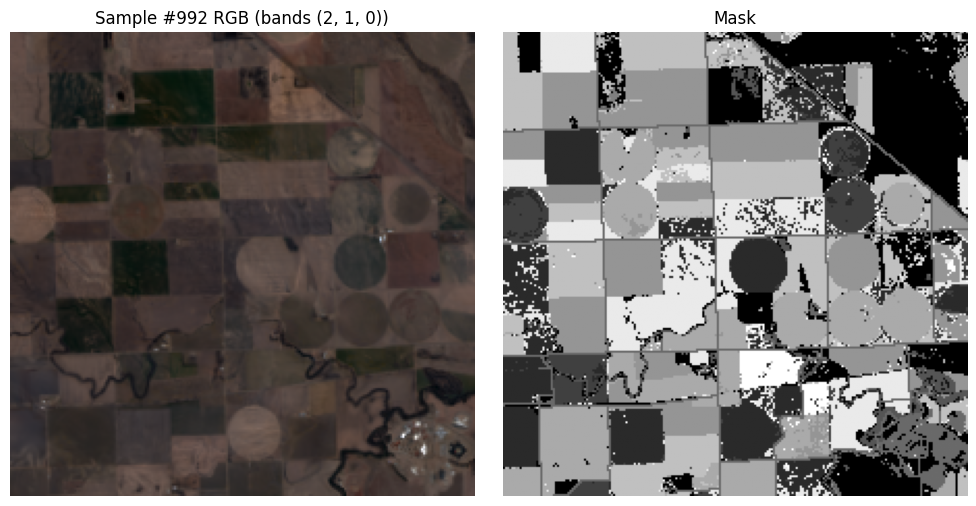

tensor([[[ 1.2287,  1.1796,  0.9374,  ...,  0.9690,  0.9795,  0.9725],
         [ 1.2112,  1.0181,  0.9936,  ...,  1.0638,  1.0076,  1.0287],
         [ 1.1971,  1.0708,  1.1164,  ...,  1.0848,  0.9760,  1.0217],
         ...,
         [ 0.9515,  0.7795,  0.9655,  ...,  1.3796,  1.2322,  1.1059],
         [ 1.0918,  0.8216,  1.0813,  ...,  1.2779,  1.0181,  0.9971],
         [ 0.8462,  0.9234,  1.0638,  ...,  1.5551,  0.8848,  0.9479]],

        [[ 1.1311,  1.1255,  0.8349,  ...,  0.8712,  0.9243,  0.8796],
         [ 1.1227,  0.9215,  0.8964,  ...,  0.9774,  0.8768,  1.0025],
         [ 1.1311,  0.9634,  1.0081,  ...,  1.0193,  0.9159,  0.9383],
         ...,
         [ 0.9243,  0.6924,  0.7231,  ...,  1.5335,  1.2513,  1.1059],
         [ 0.9802,  0.6085,  0.8572,  ...,  1.4357,  1.0501,  1.0081],
         [ 0.6476,  0.6616,  0.8265,  ...,  1.6648,  0.9383,  0.9802]],

        [[ 1.2695,  1.2226,  1.0193,  ...,  1.2278,  1.2590,  1.2538],
         [ 1.2382,  1.0801,  1.1027,  ...,  1

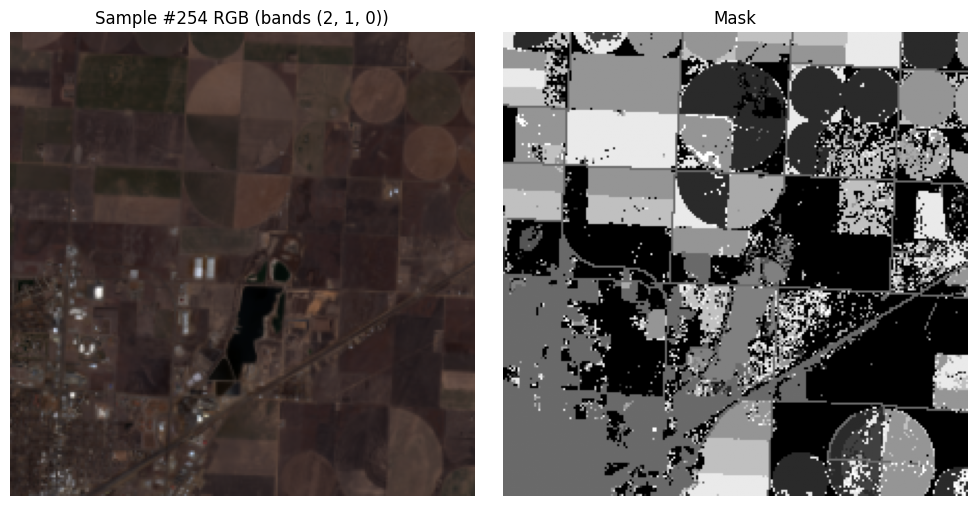

In [ ]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [ ]:
model = DeepLabV3Plus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)


class_weights = torch.tensor( [ 0, 0.386375, 0.661126, 0.548184, 0.640482, 0.876862, 0.925186, 3.249462, 1.542289, 2.175141, 2.272419, 3.062762, 3.626097, 1.198702], device = DEVICE)
ce_loss = nn.CrossEntropyLoss(
    weight=class_weights,
    ignore_index=0
)

def criterion(preds, targets):
    targets = targets.long()

    L_ce = ce_loss(preds, targets)

    return 1 * L_ce



optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )

def lr_lambda(cur_step):
    if cur_step < 1500:
        return cur_step / 1500 * (1 - 1e-6) + 1e-6
    else:
        return (1 - (cur_step - 1500) / (max_iters - 1500)) ** 1.0

max_iters = len(train_loader) * EPOCHS
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/100: 100%|██████████| 309/309 [12:52<00:00,  2.50s/it]


[Epoch  0] Loss:  2.6918, Acc:   0.0776, IoU:   0.0277, Dice:  0.0356, mIoU:  0.0209


Epoch 1/100 [Val]: 100%|██████████| 78/78 [01:45<00:00,  1.35s/it]


[Epoch  0] Loss: 2.7120, Acc: 0.0807, IoU: 0.0283, Dice: 0.0348, mIoU: 0.0204


Epoch 2/100: 100%|██████████| 309/309 [05:41<00:00,  1.11s/it]


[Epoch  1] Loss:  2.6911, Acc:   0.0775, IoU:   0.0278, Dice:  0.0358, mIoU:  0.0210


Epoch 2/100 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.02s/it]


[Epoch  1] Loss: 2.7402, Acc: 0.0808, IoU: 0.0291, Dice: 0.0355, mIoU: 0.0208


Epoch 3/100: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch  2] Loss:  2.6897, Acc:   0.0780, IoU:   0.0279, Dice:  0.0358, mIoU:  0.0211


Epoch 3/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch  2] Loss: 2.6847, Acc: 0.0818, IoU: 0.0295, Dice: 0.0364, mIoU: 0.0213


Epoch 4/100: 100%|██████████| 309/309 [05:33<00:00,  1.08s/it]


[Epoch  3] Loss:  2.6889, Acc:   0.0781, IoU:   0.0281, Dice:  0.0359, mIoU:  0.0211


Epoch 4/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch  3] Loss: 2.7514, Acc: 0.0830, IoU: 0.0300, Dice: 0.0360, mIoU: 0.0212


Epoch 5/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch  4] Loss:  2.6884, Acc:   0.0786, IoU:   0.0282, Dice:  0.0360, mIoU:  0.0212


Epoch 5/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch  4] Loss: 2.6869, Acc: 0.0827, IoU: 0.0294, Dice: 0.0361, mIoU: 0.0211


Epoch 6/100: 100%|██████████| 309/309 [05:31<00:00,  1.07s/it]


[Epoch  5] Loss:  2.6867, Acc:   0.0790, IoU:   0.0284, Dice:  0.0361, mIoU:  0.0213


Epoch 6/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.22s/it]


[Epoch  5] Loss: 2.7563, Acc: 0.0842, IoU: 0.0304, Dice: 0.0357, mIoU: 0.0210


Epoch 7/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch  6] Loss:  2.6845, Acc:   0.0799, IoU:   0.0287, Dice:  0.0362, mIoU:  0.0213


Epoch 7/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch  6] Loss: 2.6850, Acc: 0.0821, IoU: 0.0299, Dice: 0.0364, mIoU: 0.0213


Epoch 8/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch  7] Loss:  2.6844, Acc:   0.0801, IoU:   0.0287, Dice:  0.0364, mIoU:  0.0214


Epoch 8/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.18it/s]


[Epoch  7] Loss: 2.7334, Acc: 0.0832, IoU: 0.0302, Dice: 0.0361, mIoU: 0.0212


Epoch 9/100: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch  8] Loss:  2.6830, Acc:   0.0800, IoU:   0.0287, Dice:  0.0362, mIoU:  0.0213


Epoch 9/100 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.18s/it]


[Epoch  8] Loss: 2.7219, Acc: 0.0847, IoU: 0.0302, Dice: 0.0363, mIoU: 0.0213


Epoch 10/100: 100%|██████████| 309/309 [05:56<00:00,  1.15s/it]


[Epoch  9] Loss:  2.6808, Acc:   0.0809, IoU:   0.0292, Dice:  0.0366, mIoU:  0.0216


Epoch 10/100 [Val]: 100%|██████████| 78/78 [01:05<00:00,  1.20it/s]


[Epoch  9] Loss: 2.7172, Acc: 0.0854, IoU: 0.0307, Dice: 0.0366, mIoU: 0.0215


Epoch 11/100: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 10] Loss:  2.6799, Acc:   0.0809, IoU:   0.0291, Dice:  0.0366, mIoU:  0.0216


Epoch 11/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 10] Loss: 2.6876, Acc: 0.0862, IoU: 0.0303, Dice: 0.0362, mIoU: 0.0212


Epoch 12/100: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch 11] Loss:  2.6802, Acc:   0.0812, IoU:   0.0292, Dice:  0.0366, mIoU:  0.0216


Epoch 12/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.18it/s]


[Epoch 11] Loss: 2.6990, Acc: 0.0868, IoU: 0.0311, Dice: 0.0364, mIoU: 0.0214


Epoch 13/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch 12] Loss:  2.6787, Acc:   0.0817, IoU:   0.0294, Dice:  0.0368, mIoU:  0.0217


Epoch 13/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch 12] Loss: 2.6840, Acc: 0.0856, IoU: 0.0314, Dice: 0.0372, mIoU: 0.0219


Epoch 14/100: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 13] Loss:  2.6772, Acc:   0.0824, IoU:   0.0297, Dice:  0.0369, mIoU:  0.0217


Epoch 14/100 [Val]: 100%|██████████| 78/78 [01:05<00:00,  1.18it/s]


[Epoch 13] Loss: 2.6818, Acc: 0.0873, IoU: 0.0314, Dice: 0.0372, mIoU: 0.0218


Epoch 15/100: 100%|██████████| 309/309 [06:03<00:00,  1.18s/it]


[Epoch 14] Loss:  2.6757, Acc:   0.0832, IoU:   0.0300, Dice:  0.0372, mIoU:  0.0219


Epoch 15/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.23s/it]


[Epoch 14] Loss: 2.7077, Acc: 0.0863, IoU: 0.0311, Dice: 0.0368, mIoU: 0.0216


Epoch 16/100: 100%|██████████| 309/309 [06:03<00:00,  1.18s/it]


[Epoch 15] Loss:  2.6751, Acc:   0.0835, IoU:   0.0300, Dice:  0.0371, mIoU:  0.0219


Epoch 16/100 [Val]: 100%|██████████| 78/78 [01:20<00:00,  1.04s/it]


[Epoch 15] Loss: 2.6833, Acc: 0.0873, IoU: 0.0315, Dice: 0.0369, mIoU: 0.0216


Epoch 17/100: 100%|██████████| 309/309 [05:47<00:00,  1.12s/it]


[Epoch 16] Loss:  2.6745, Acc:   0.0836, IoU:   0.0301, Dice:  0.0372, mIoU:  0.0219


Epoch 17/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 16] Loss: 2.7435, Acc: 0.0894, IoU: 0.0322, Dice: 0.0369, mIoU: 0.0218


Epoch 18/100: 100%|██████████| 309/309 [06:04<00:00,  1.18s/it]


[Epoch 17] Loss:  2.6741, Acc:   0.0838, IoU:   0.0302, Dice:  0.0372, mIoU:  0.0219


Epoch 18/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch 17] Loss: 2.6558, Acc: 0.0872, IoU: 0.0322, Dice: 0.0383, mIoU: 0.0225


Epoch 19/100: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 18] Loss:  2.6726, Acc:   0.0845, IoU:   0.0304, Dice:  0.0374, mIoU:  0.0221


Epoch 19/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


[Epoch 18] Loss: 2.6888, Acc: 0.0907, IoU: 0.0326, Dice: 0.0375, mIoU: 0.0221


Epoch 20/100: 100%|██████████| 309/309 [06:04<00:00,  1.18s/it]


[Epoch 19] Loss:  2.6707, Acc:   0.0844, IoU:   0.0305, Dice:  0.0375, mIoU:  0.0221


Epoch 20/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 19] Loss: 2.6962, Acc: 0.0904, IoU: 0.0327, Dice: 0.0376, mIoU: 0.0221


Epoch 21/100: 100%|██████████| 309/309 [05:52<00:00,  1.14s/it]


[Epoch 20] Loss:  2.6701, Acc:   0.0851, IoU:   0.0305, Dice:  0.0374, mIoU:  0.0221


Epoch 21/100 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.15it/s]


[Epoch 20] Loss: 2.6808, Acc: 0.0919, IoU: 0.0323, Dice: 0.0368, mIoU: 0.0216


Epoch 22/100: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 21] Loss:  2.6677, Acc:   0.0867, IoU:   0.0312, Dice:  0.0378, mIoU:  0.0223


Epoch 22/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.22s/it]


[Epoch 21] Loss: 2.6771, Acc: 0.0914, IoU: 0.0336, Dice: 0.0385, mIoU: 0.0226


Epoch 23/100: 100%|██████████| 309/309 [05:47<00:00,  1.13s/it]


[Epoch 22] Loss:  2.6672, Acc:   0.0862, IoU:   0.0308, Dice:  0.0376, mIoU:  0.0222


Epoch 23/100 [Val]: 100%|██████████| 78/78 [01:22<00:00,  1.06s/it]


[Epoch 22] Loss: 2.6897, Acc: 0.0919, IoU: 0.0327, Dice: 0.0370, mIoU: 0.0218


Epoch 24/100: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 23] Loss:  2.6667, Acc:   0.0862, IoU:   0.0310, Dice:  0.0377, mIoU:  0.0222


Epoch 24/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch 23] Loss: 2.6542, Acc: 0.0920, IoU: 0.0333, Dice: 0.0381, mIoU: 0.0224


Epoch 25/100: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch 24] Loss:  2.6654, Acc:   0.0870, IoU:   0.0313, Dice:  0.0379, mIoU:  0.0224


Epoch 25/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 24] Loss: 2.6581, Acc: 0.0940, IoU: 0.0340, Dice: 0.0387, mIoU: 0.0228


Epoch 26/100: 100%|██████████| 309/309 [05:47<00:00,  1.13s/it]


[Epoch 25] Loss:  2.6659, Acc:   0.0867, IoU:   0.0312, Dice:  0.0379, mIoU:  0.0224


Epoch 26/100 [Val]: 100%|██████████| 78/78 [01:23<00:00,  1.07s/it]


[Epoch 25] Loss: 2.6919, Acc: 0.0936, IoU: 0.0343, Dice: 0.0389, mIoU: 0.0229


Epoch 27/100: 100%|██████████| 309/309 [06:06<00:00,  1.19s/it]


[Epoch 26] Loss:  2.6620, Acc:   0.0882, IoU:   0.0316, Dice:  0.0380, mIoU:  0.0224


Epoch 27/100 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.02s/it]


[Epoch 26] Loss: 2.6777, Acc: 0.0947, IoU: 0.0344, Dice: 0.0389, mIoU: 0.0229


Epoch 28/100: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch 27] Loss:  2.6620, Acc:   0.0890, IoU:   0.0320, Dice:  0.0382, mIoU:  0.0226


Epoch 28/100 [Val]: 100%|██████████| 78/78 [01:21<00:00,  1.05s/it]


[Epoch 27] Loss: 2.6935, Acc: 0.0959, IoU: 0.0345, Dice: 0.0383, mIoU: 0.0226


Epoch 29/100: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 28] Loss:  2.6621, Acc:   0.0884, IoU:   0.0317, Dice:  0.0382, mIoU:  0.0226


Epoch 29/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 28] Loss: 2.7119, Acc: 0.0952, IoU: 0.0343, Dice: 0.0381, mIoU: 0.0226


Epoch 30/100: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch 29] Loss:  2.6607, Acc:   0.0897, IoU:   0.0322, Dice:  0.0385, mIoU:  0.0227


Epoch 30/100 [Val]: 100%|██████████| 78/78 [01:17<00:00,  1.00it/s]


[Epoch 29] Loss: 2.6793, Acc: 0.0962, IoU: 0.0351, Dice: 0.0388, mIoU: 0.0229


Epoch 31/100: 100%|██████████| 309/309 [05:41<00:00,  1.10s/it]


[Epoch 30] Loss:  2.6586, Acc:   0.0900, IoU:   0.0322, Dice:  0.0385, mIoU:  0.0228


Epoch 31/100 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.19s/it]


[Epoch 30] Loss: 2.6855, Acc: 0.0963, IoU: 0.0351, Dice: 0.0384, mIoU: 0.0226


Epoch 32/100: 100%|██████████| 309/309 [05:51<00:00,  1.14s/it]


[Epoch 31] Loss:  2.6596, Acc:   0.0899, IoU:   0.0322, Dice:  0.0384, mIoU:  0.0227


Epoch 32/100 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.19s/it]


[Epoch 31] Loss: 2.6741, Acc: 0.0986, IoU: 0.0348, Dice: 0.0384, mIoU: 0.0226


Epoch 33/100: 100%|██████████| 309/309 [05:30<00:00,  1.07s/it]


[Epoch 32] Loss:  2.6585, Acc:   0.0904, IoU:   0.0324, Dice:  0.0386, mIoU:  0.0228


Epoch 33/100 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.19s/it]


[Epoch 32] Loss: 2.6618, Acc: 0.0983, IoU: 0.0360, Dice: 0.0398, mIoU: 0.0235


Epoch 34/100: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 33] Loss:  2.6580, Acc:   0.0911, IoU:   0.0327, Dice:  0.0387, mIoU:  0.0229


Epoch 34/100 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.18s/it]


[Epoch 33] Loss: 2.6760, Acc: 0.0969, IoU: 0.0355, Dice: 0.0392, mIoU: 0.0232


Epoch 35/100: 100%|██████████| 309/309 [05:48<00:00,  1.13s/it]


[Epoch 34] Loss:  2.6564, Acc:   0.0913, IoU:   0.0328, Dice:  0.0387, mIoU:  0.0229


Epoch 35/100 [Val]: 100%|██████████| 78/78 [01:08<00:00,  1.14it/s]


[Epoch 34] Loss: 2.6961, Acc: 0.0982, IoU: 0.0357, Dice: 0.0391, mIoU: 0.0231


Epoch 36/100: 100%|██████████| 309/309 [05:52<00:00,  1.14s/it]


[Epoch 35] Loss:  2.6551, Acc:   0.0921, IoU:   0.0330, Dice:  0.0389, mIoU:  0.0230


Epoch 36/100 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.17s/it]


[Epoch 35] Loss: 2.6976, Acc: 0.1005, IoU: 0.0359, Dice: 0.0394, mIoU: 0.0233


Epoch 37/100: 100%|██████████| 309/309 [05:32<00:00,  1.08s/it]


[Epoch 36] Loss:  2.6529, Acc:   0.0932, IoU:   0.0334, Dice:  0.0393, mIoU:  0.0233


Epoch 37/100 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.18s/it]


[Epoch 36] Loss: 2.6657, Acc: 0.0978, IoU: 0.0353, Dice: 0.0390, mIoU: 0.0230


Epoch 38/100: 100%|██████████| 309/309 [05:56<00:00,  1.16s/it]


[Epoch 37] Loss:  2.6527, Acc:   0.0933, IoU:   0.0334, Dice:  0.0392, mIoU:  0.0232


Epoch 38/100 [Val]: 100%|██████████| 78/78 [01:30<00:00,  1.16s/it]


[Epoch 37] Loss: 2.6737, Acc: 0.1003, IoU: 0.0360, Dice: 0.0392, mIoU: 0.0231


Epoch 39/100: 100%|██████████| 309/309 [05:37<00:00,  1.09s/it]


[Epoch 38] Loss:  2.6511, Acc:   0.0935, IoU:   0.0335, Dice:  0.0390, mIoU:  0.0231


Epoch 39/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 38] Loss: 2.6934, Acc: 0.1022, IoU: 0.0365, Dice: 0.0391, mIoU: 0.0232


Epoch 40/100: 100%|██████████| 309/309 [06:04<00:00,  1.18s/it]


[Epoch 39] Loss:  2.6509, Acc:   0.0940, IoU:   0.0336, Dice:  0.0393, mIoU:  0.0232


Epoch 40/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 39] Loss: 2.6878, Acc: 0.1021, IoU: 0.0366, Dice: 0.0392, mIoU: 0.0232


Epoch 41/100: 100%|██████████| 309/309 [05:46<00:00,  1.12s/it]


[Epoch 40] Loss:  2.6503, Acc:   0.0941, IoU:   0.0337, Dice:  0.0393, mIoU:  0.0233


Epoch 41/100 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.02s/it]


[Epoch 40] Loss: 2.6507, Acc: 0.1020, IoU: 0.0369, Dice: 0.0396, mIoU: 0.0234


Epoch 42/100: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 41] Loss:  2.6478, Acc:   0.0951, IoU:   0.0340, Dice:  0.0394, mIoU:  0.0233


Epoch 42/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 41] Loss: 2.6676, Acc: 0.1022, IoU: 0.0378, Dice: 0.0404, mIoU: 0.0240


Epoch 43/100: 100%|██████████| 309/309 [05:28<00:00,  1.06s/it]


[Epoch 42] Loss:  2.6468, Acc:   0.0957, IoU:   0.0341, Dice:  0.0394, mIoU:  0.0233


Epoch 43/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 42] Loss: 2.6793, Acc: 0.1023, IoU: 0.0370, Dice: 0.0398, mIoU: 0.0236


Epoch 44/100: 100%|██████████| 309/309 [05:56<00:00,  1.15s/it]


[Epoch 43] Loss:  2.6463, Acc:   0.0968, IoU:   0.0346, Dice:  0.0398, mIoU:  0.0236


Epoch 44/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 43] Loss: 2.6572, Acc: 0.1037, IoU: 0.0374, Dice: 0.0403, mIoU: 0.0238


Epoch 45/100: 100%|██████████| 309/309 [05:28<00:00,  1.06s/it]


[Epoch 44] Loss:  2.6456, Acc:   0.0962, IoU:   0.0344, Dice:  0.0398, mIoU:  0.0236


Epoch 45/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch 44] Loss: 2.6797, Acc: 0.1047, IoU: 0.0376, Dice: 0.0396, mIoU: 0.0235


Epoch 46/100: 100%|██████████| 309/309 [06:07<00:00,  1.19s/it]


[Epoch 45] Loss:  2.6459, Acc:   0.0968, IoU:   0.0345, Dice:  0.0399, mIoU:  0.0236


Epoch 46/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch 45] Loss: 2.6563, Acc: 0.1058, IoU: 0.0378, Dice: 0.0402, mIoU: 0.0238


Epoch 47/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch 46] Loss:  2.6447, Acc:   0.0971, IoU:   0.0345, Dice:  0.0398, mIoU:  0.0236


Epoch 47/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.18it/s]


[Epoch 46] Loss: 2.6603, Acc: 0.1058, IoU: 0.0377, Dice: 0.0400, mIoU: 0.0237


Epoch 48/100: 100%|██████████| 309/309 [05:56<00:00,  1.15s/it]


[Epoch 47] Loss:  2.6433, Acc:   0.0985, IoU:   0.0351, Dice:  0.0398, mIoU:  0.0236


Epoch 48/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 47] Loss: 2.6375, Acc: 0.1086, IoU: 0.0387, Dice: 0.0403, mIoU: 0.0239


Epoch 49/100: 100%|██████████| 309/309 [05:53<00:00,  1.14s/it]


[Epoch 48] Loss:  2.6432, Acc:   0.0986, IoU:   0.0350, Dice:  0.0400, mIoU:  0.0237


Epoch 49/100 [Val]: 100%|██████████| 78/78 [01:29<00:00,  1.15s/it]


[Epoch 48] Loss: 2.6489, Acc: 0.1082, IoU: 0.0394, Dice: 0.0409, mIoU: 0.0243


Epoch 50/100: 100%|██████████| 309/309 [05:22<00:00,  1.05s/it]


[Epoch 49] Loss:  2.6419, Acc:   0.0988, IoU:   0.0351, Dice:  0.0403, mIoU:  0.0239


Epoch 50/100 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.19s/it]


[Epoch 49] Loss: 2.6683, Acc: 0.1095, IoU: 0.0383, Dice: 0.0397, mIoU: 0.0236


Epoch 51/100: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 50] Loss:  2.6413, Acc:   0.0992, IoU:   0.0352, Dice:  0.0403, mIoU:  0.0239


Epoch 51/100 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.20it/s]


[Epoch 50] Loss: 2.6414, Acc: 0.1107, IoU: 0.0396, Dice: 0.0407, mIoU: 0.0242


Epoch 52/100: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 51] Loss:  2.6401, Acc:   0.1001, IoU:   0.0356, Dice:  0.0404, mIoU:  0.0240


Epoch 52/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 51] Loss: 2.6572, Acc: 0.1083, IoU: 0.0383, Dice: 0.0402, mIoU: 0.0239


Epoch 53/100: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 52] Loss:  2.6399, Acc:   0.0993, IoU:   0.0353, Dice:  0.0404, mIoU:  0.0240


Epoch 53/100 [Val]: 100%|██████████| 78/78 [01:05<00:00,  1.20it/s]


[Epoch 52] Loss: 2.6751, Acc: 0.1072, IoU: 0.0382, Dice: 0.0397, mIoU: 0.0235


Epoch 54/100: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 53] Loss:  2.6388, Acc:   0.1013, IoU:   0.0357, Dice:  0.0406, mIoU:  0.0241


Epoch 54/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch 53] Loss: 2.6349, Acc: 0.1099, IoU: 0.0391, Dice: 0.0406, mIoU: 0.0241


Epoch 55/100: 100%|██████████| 309/309 [05:28<00:00,  1.06s/it]


[Epoch 54] Loss:  2.6368, Acc:   0.1007, IoU:   0.0358, Dice:  0.0405, mIoU:  0.0241


Epoch 55/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch 54] Loss: 2.6472, Acc: 0.1103, IoU: 0.0395, Dice: 0.0405, mIoU: 0.0241


Epoch 56/100: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch 55] Loss:  2.6365, Acc:   0.1025, IoU:   0.0361, Dice:  0.0407, mIoU:  0.0242


Epoch 56/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 55] Loss: 2.6555, Acc: 0.1110, IoU: 0.0393, Dice: 0.0407, mIoU: 0.0242


Epoch 57/100: 100%|██████████| 309/309 [05:25<00:00,  1.05s/it]


[Epoch 56] Loss:  2.6364, Acc:   0.1022, IoU:   0.0361, Dice:  0.0408, mIoU:  0.0243


Epoch 57/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 56] Loss: 2.6417, Acc: 0.1111, IoU: 0.0393, Dice: 0.0406, mIoU: 0.0241


Epoch 58/100: 100%|██████████| 309/309 [05:56<00:00,  1.15s/it]


[Epoch 57] Loss:  2.6345, Acc:   0.1037, IoU:   0.0366, Dice:  0.0410, mIoU:  0.0244


Epoch 58/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.21s/it]


[Epoch 57] Loss: 2.6604, Acc: 0.1153, IoU: 0.0408, Dice: 0.0412, mIoU: 0.0246


Epoch 59/100: 100%|██████████| 309/309 [05:34<00:00,  1.08s/it]


[Epoch 58] Loss:  2.6345, Acc:   0.1034, IoU:   0.0365, Dice:  0.0410, mIoU:  0.0244


Epoch 59/100 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.02s/it]


[Epoch 58] Loss: 2.6520, Acc: 0.1145, IoU: 0.0405, Dice: 0.0407, mIoU: 0.0242


Epoch 60/100: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch 59] Loss:  2.6346, Acc:   0.1028, IoU:   0.0365, Dice:  0.0411, mIoU:  0.0244


Epoch 60/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.19s/it]


[Epoch 59] Loss: 2.6297, Acc: 0.1160, IoU: 0.0412, Dice: 0.0418, mIoU: 0.0249


Epoch 61/100: 100%|██████████| 309/309 [05:28<00:00,  1.06s/it]


[Epoch 60] Loss:  2.6317, Acc:   0.1040, IoU:   0.0367, Dice:  0.0410, mIoU:  0.0244


Epoch 61/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 60] Loss: 2.6337, Acc: 0.1184, IoU: 0.0416, Dice: 0.0421, mIoU: 0.0251


Epoch 62/100: 100%|██████████| 309/309 [06:01<00:00,  1.17s/it]


[Epoch 61] Loss:  2.6343, Acc:   0.1035, IoU:   0.0365, Dice:  0.0411, mIoU:  0.0244


Epoch 62/100 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.02s/it]


[Epoch 61] Loss: 2.6430, Acc: 0.1164, IoU: 0.0408, Dice: 0.0408, mIoU: 0.0243


Epoch 63/100: 100%|██████████| 309/309 [05:46<00:00,  1.12s/it]


[Epoch 62] Loss:  2.6287, Acc:   0.1057, IoU:   0.0371, Dice:  0.0412, mIoU:  0.0245


Epoch 63/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 62] Loss: 2.6694, Acc: 0.1171, IoU: 0.0417, Dice: 0.0415, mIoU: 0.0248


Epoch 64/100: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 63] Loss:  2.6301, Acc:   0.1062, IoU:   0.0373, Dice:  0.0415, mIoU:  0.0247


Epoch 64/100 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.19s/it]


[Epoch 63] Loss: 2.6338, Acc: 0.1191, IoU: 0.0418, Dice: 0.0420, mIoU: 0.0251


Epoch 65/100: 100%|██████████| 309/309 [05:30<00:00,  1.07s/it]


[Epoch 64] Loss:  2.6299, Acc:   0.1060, IoU:   0.0372, Dice:  0.0413, mIoU:  0.0246


Epoch 65/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.22s/it]


[Epoch 64] Loss: 2.6180, Acc: 0.1196, IoU: 0.0424, Dice: 0.0424, mIoU: 0.0253


Epoch 66/100: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 65] Loss:  2.6274, Acc:   0.1067, IoU:   0.0374, Dice:  0.0415, mIoU:  0.0247


Epoch 66/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 65] Loss: 2.6324, Acc: 0.1200, IoU: 0.0428, Dice: 0.0430, mIoU: 0.0257


Epoch 67/100: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch 66] Loss:  2.6272, Acc:   0.1071, IoU:   0.0376, Dice:  0.0415, mIoU:  0.0247


Epoch 67/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


[Epoch 66] Loss: 2.6652, Acc: 0.1214, IoU: 0.0422, Dice: 0.0421, mIoU: 0.0253


Epoch 68/100: 100%|██████████| 309/309 [05:54<00:00,  1.15s/it]


[Epoch 67] Loss:  2.6246, Acc:   0.1084, IoU:   0.0379, Dice:  0.0417, mIoU:  0.0248


Epoch 68/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.19s/it]


[Epoch 67] Loss: 2.6318, Acc: 0.1216, IoU: 0.0427, Dice: 0.0420, mIoU: 0.0251


Epoch 69/100: 100%|██████████| 309/309 [05:51<00:00,  1.14s/it]


[Epoch 68] Loss:  2.6265, Acc:   0.1074, IoU:   0.0377, Dice:  0.0416, mIoU:  0.0248


Epoch 69/100 [Val]: 100%|██████████| 78/78 [01:03<00:00,  1.23it/s]


[Epoch 68] Loss: 2.6051, Acc: 0.1221, IoU: 0.0434, Dice: 0.0429, mIoU: 0.0257


Epoch 70/100: 100%|██████████| 309/309 [05:53<00:00,  1.15s/it]


[Epoch 69] Loss:  2.6239, Acc:   0.1091, IoU:   0.0382, Dice:  0.0419, mIoU:  0.0249


Epoch 70/100 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.18s/it]


[Epoch 69] Loss: 2.6514, Acc: 0.1226, IoU: 0.0425, Dice: 0.0416, mIoU: 0.0249


Epoch 71/100: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch 70] Loss:  2.6226, Acc:   0.1102, IoU:   0.0383, Dice:  0.0420, mIoU:  0.0250


Epoch 71/100 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.21it/s]


[Epoch 70] Loss: 2.6391, Acc: 0.1233, IoU: 0.0435, Dice: 0.0428, mIoU: 0.0257


Epoch 72/100: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch 71] Loss:  2.6217, Acc:   0.1106, IoU:   0.0385, Dice:  0.0422, mIoU:  0.0251


Epoch 72/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 71] Loss: 2.6282, Acc: 0.1265, IoU: 0.0436, Dice: 0.0424, mIoU: 0.0254


Epoch 73/100: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 72] Loss:  2.6228, Acc:   0.1108, IoU:   0.0385, Dice:  0.0420, mIoU:  0.0250


Epoch 73/100 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.21it/s]


[Epoch 72] Loss: 2.6352, Acc: 0.1277, IoU: 0.0435, Dice: 0.0418, mIoU: 0.0251


Epoch 74/100: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 73] Loss:  2.6217, Acc:   0.1104, IoU:   0.0386, Dice:  0.0421, mIoU:  0.0251


Epoch 74/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 73] Loss: 2.6346, Acc: 0.1289, IoU: 0.0439, Dice: 0.0417, mIoU: 0.0251


Epoch 75/100: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 74] Loss:  2.6190, Acc:   0.1116, IoU:   0.0389, Dice:  0.0422, mIoU:  0.0251


Epoch 75/100 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.20it/s]


[Epoch 74] Loss: 2.6448, Acc: 0.1248, IoU: 0.0443, Dice: 0.0435, mIoU: 0.0261


Epoch 76/100: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 75] Loss:  2.6192, Acc:   0.1114, IoU:   0.0388, Dice:  0.0423, mIoU:  0.0252


Epoch 76/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch 75] Loss: 2.6480, Acc: 0.1249, IoU: 0.0431, Dice: 0.0424, mIoU: 0.0255


Epoch 77/100: 100%|██████████| 309/309 [05:25<00:00,  1.05s/it]


[Epoch 76] Loss:  2.6189, Acc:   0.1119, IoU:   0.0390, Dice:  0.0422, mIoU:  0.0252


Epoch 77/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.23s/it]


[Epoch 76] Loss: 2.6111, Acc: 0.1263, IoU: 0.0444, Dice: 0.0430, mIoU: 0.0258


Epoch 78/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch 77] Loss:  2.6162, Acc:   0.1136, IoU:   0.0394, Dice:  0.0426, mIoU:  0.0254


Epoch 78/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 77] Loss: 2.6192, Acc: 0.1237, IoU: 0.0444, Dice: 0.0435, mIoU: 0.0261


Epoch 79/100: 100%|██████████| 309/309 [05:53<00:00,  1.14s/it]


[Epoch 78] Loss:  2.6164, Acc:   0.1125, IoU:   0.0391, Dice:  0.0426, mIoU:  0.0254


Epoch 79/100 [Val]: 100%|██████████| 78/78 [01:05<00:00,  1.19it/s]


[Epoch 78] Loss: 2.6165, Acc: 0.1249, IoU: 0.0441, Dice: 0.0430, mIoU: 0.0258


Epoch 80/100: 100%|██████████| 309/309 [05:56<00:00,  1.16s/it]


[Epoch 79] Loss:  2.6163, Acc:   0.1138, IoU:   0.0393, Dice:  0.0425, mIoU:  0.0254


Epoch 80/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 79] Loss: 2.6376, Acc: 0.1272, IoU: 0.0446, Dice: 0.0434, mIoU: 0.0261


Epoch 81/100: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch 80] Loss:  2.6165, Acc:   0.1138, IoU:   0.0393, Dice:  0.0426, mIoU:  0.0254


Epoch 81/100 [Val]: 100%|██████████| 78/78 [01:08<00:00,  1.14it/s]


[Epoch 80] Loss: 2.6180, Acc: 0.1301, IoU: 0.0452, Dice: 0.0435, mIoU: 0.0262


Epoch 82/100: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch 81] Loss:  2.6147, Acc:   0.1147, IoU:   0.0396, Dice:  0.0426, mIoU:  0.0255


Epoch 82/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 81] Loss: 2.6060, Acc: 0.1300, IoU: 0.0460, Dice: 0.0434, mIoU: 0.0260


Epoch 83/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch 82] Loss:  2.6147, Acc:   0.1152, IoU:   0.0398, Dice:  0.0429, mIoU:  0.0256


Epoch 83/100 [Val]: 100%|██████████| 78/78 [01:05<00:00,  1.18it/s]


[Epoch 82] Loss: 2.6230, Acc: 0.1298, IoU: 0.0448, Dice: 0.0434, mIoU: 0.0261


Epoch 84/100: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch 83] Loss:  2.6132, Acc:   0.1149, IoU:   0.0397, Dice:  0.0428, mIoU:  0.0256


Epoch 84/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 83] Loss: 2.6140, Acc: 0.1287, IoU: 0.0462, Dice: 0.0443, mIoU: 0.0266


Epoch 85/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch 84] Loss:  2.6087, Acc:   0.1182, IoU:   0.0406, Dice:  0.0432, mIoU:  0.0258


Epoch 85/100 [Val]: 100%|██████████| 78/78 [01:30<00:00,  1.16s/it]


[Epoch 84] Loss: 2.6107, Acc: 0.1320, IoU: 0.0460, Dice: 0.0435, mIoU: 0.0262


Epoch 86/100: 100%|██████████| 309/309 [05:30<00:00,  1.07s/it]


[Epoch 85] Loss:  2.6099, Acc:   0.1174, IoU:   0.0404, Dice:  0.0433, mIoU:  0.0259


Epoch 86/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.19s/it]


[Epoch 85] Loss: 2.5885, Acc: 0.1329, IoU: 0.0475, Dice: 0.0441, mIoU: 0.0266


Epoch 87/100: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch 86] Loss:  2.6117, Acc:   0.1176, IoU:   0.0405, Dice:  0.0432, mIoU:  0.0259


Epoch 87/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 86] Loss: 2.6092, Acc: 0.1370, IoU: 0.0466, Dice: 0.0441, mIoU: 0.0266


Epoch 88/100: 100%|██████████| 309/309 [05:35<00:00,  1.08s/it]


[Epoch 87] Loss:  2.6086, Acc:   0.1180, IoU:   0.0405, Dice:  0.0432, mIoU:  0.0259


Epoch 88/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch 87] Loss: 2.6465, Acc: 0.1381, IoU: 0.0442, Dice: 0.0423, mIoU: 0.0255


Epoch 89/100: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 88] Loss:  2.6089, Acc:   0.1187, IoU:   0.0407, Dice:  0.0434, mIoU:  0.0260


Epoch 89/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.23s/it]


[Epoch 88] Loss: 2.6065, Acc: 0.1349, IoU: 0.0455, Dice: 0.0435, mIoU: 0.0262


Epoch 90/100: 100%|██████████| 309/309 [06:01<00:00,  1.17s/it]


[Epoch 89] Loss:  2.6079, Acc:   0.1190, IoU:   0.0408, Dice:  0.0434, mIoU:  0.0260


Epoch 90/100 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.16it/s]


[Epoch 89] Loss: 2.6005, Acc: 0.1380, IoU: 0.0464, Dice: 0.0436, mIoU: 0.0263


Epoch 91/100: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 90] Loss:  2.6056, Acc:   0.1195, IoU:   0.0409, Dice:  0.0435, mIoU:  0.0260


Epoch 91/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 90] Loss: 2.6486, Acc: 0.1381, IoU: 0.0455, Dice: 0.0429, mIoU: 0.0259


Epoch 92/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch 91] Loss:  2.6055, Acc:   0.1207, IoU:   0.0411, Dice:  0.0435, mIoU:  0.0260


Epoch 92/100 [Val]: 100%|██████████| 78/78 [01:09<00:00,  1.12it/s]


[Epoch 91] Loss: 2.5917, Acc: 0.1396, IoU: 0.0457, Dice: 0.0433, mIoU: 0.0262


Epoch 93/100: 100%|██████████| 309/309 [06:57<00:00,  1.35s/it]


[Epoch 92] Loss:  2.6066, Acc:   0.1214, IoU:   0.0413, Dice:  0.0439, mIoU:  0.0263


Epoch 93/100 [Val]: 100%|██████████| 78/78 [01:11<00:00,  1.09it/s]


[Epoch 92] Loss: 2.6146, Acc: 0.1364, IoU: 0.0470, Dice: 0.0441, mIoU: 0.0266


Epoch 94/100: 100%|██████████| 309/309 [06:27<00:00,  1.25s/it]


[Epoch 93] Loss:  2.6052, Acc:   0.1211, IoU:   0.0413, Dice:  0.0437, mIoU:  0.0261


Epoch 94/100 [Val]: 100%|██████████| 78/78 [01:43<00:00,  1.32s/it]


[Epoch 93] Loss: 2.6097, Acc: 0.1387, IoU: 0.0462, Dice: 0.0437, mIoU: 0.0264


Epoch 95/100: 100%|██████████| 309/309 [06:46<00:00,  1.31s/it]


[Epoch 94] Loss:  2.6034, Acc:   0.1220, IoU:   0.0417, Dice:  0.0438, mIoU:  0.0263


Epoch 95/100 [Val]: 100%|██████████| 78/78 [01:28<00:00,  1.14s/it]


[Epoch 94] Loss: 2.6026, Acc: 0.1387, IoU: 0.0470, Dice: 0.0442, mIoU: 0.0267


Epoch 96/100: 100%|██████████| 309/309 [06:25<00:00,  1.25s/it]


[Epoch 95] Loss:  2.6021, Acc:   0.1230, IoU:   0.0418, Dice:  0.0439, mIoU:  0.0263


Epoch 96/100 [Val]: 100%|██████████| 78/78 [01:40<00:00,  1.29s/it]


[Epoch 95] Loss: 2.5943, Acc: 0.1381, IoU: 0.0475, Dice: 0.0446, mIoU: 0.0269


Epoch 97/100: 100%|██████████| 309/309 [06:24<00:00,  1.24s/it]


[Epoch 96] Loss:  2.6010, Acc:   0.1221, IoU:   0.0416, Dice:  0.0439, mIoU:  0.0263


Epoch 97/100 [Val]: 100%|██████████| 78/78 [01:41<00:00,  1.30s/it]


[Epoch 96] Loss: 2.6079, Acc: 0.1370, IoU: 0.0468, Dice: 0.0444, mIoU: 0.0268


Epoch 98/100: 100%|██████████| 309/309 [06:28<00:00,  1.26s/it]


[Epoch 97] Loss:  2.5987, Acc:   0.1248, IoU:   0.0423, Dice:  0.0440, mIoU:  0.0264


Epoch 98/100 [Val]: 100%|██████████| 78/78 [01:43<00:00,  1.33s/it]


[Epoch 97] Loss: 2.5981, Acc: 0.1393, IoU: 0.0475, Dice: 0.0442, mIoU: 0.0268


Epoch 99/100: 100%|██████████| 309/309 [06:30<00:00,  1.26s/it]


[Epoch 98] Loss:  2.5977, Acc:   0.1248, IoU:   0.0423, Dice:  0.0442, mIoU:  0.0265


Epoch 99/100 [Val]: 100%|██████████| 78/78 [01:41<00:00,  1.31s/it]


[Epoch 98] Loss: 2.6055, Acc: 0.1419, IoU: 0.0471, Dice: 0.0435, mIoU: 0.0263


Epoch 100/100: 100%|██████████| 309/309 [06:29<00:00,  1.26s/it]


[Epoch 99] Loss:  2.5982, Acc:   0.1248, IoU:   0.0423, Dice:  0.0443, mIoU:  0.0266


Epoch 100/100 [Val]: 100%|██████████| 78/78 [01:41<00:00,  1.31s/it]


[Epoch 99] Loss: 2.6073, Acc: 0.1378, IoU: 0.0467, Dice: 0.0434, mIoU: 0.0262


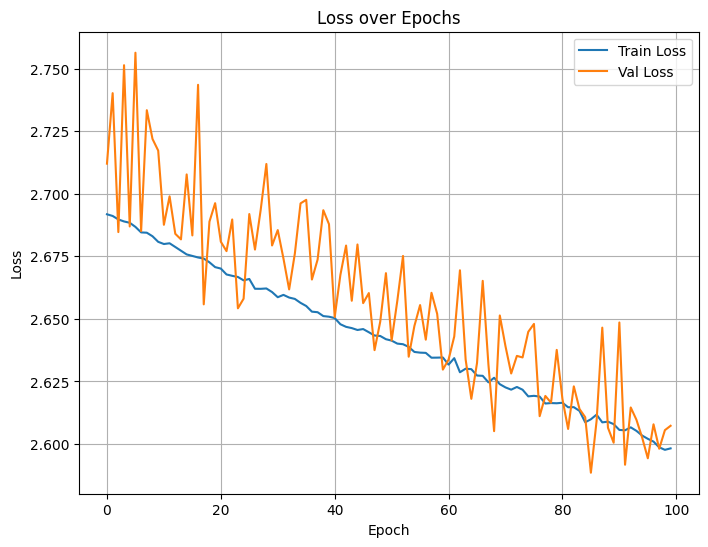

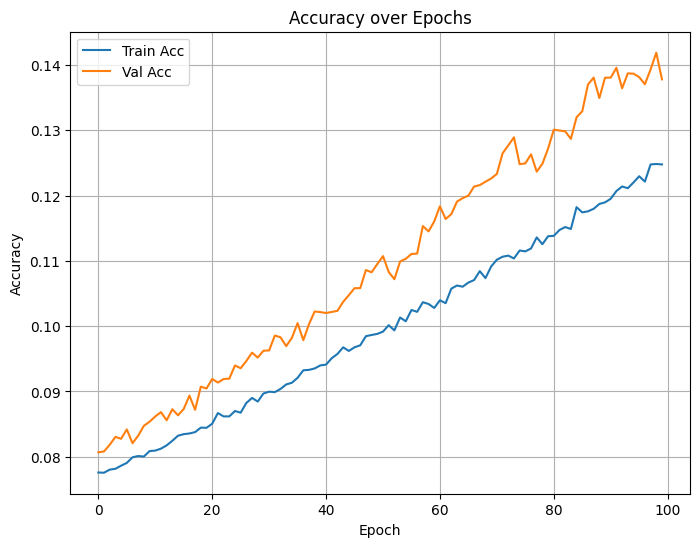

In [ ]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []
best_val_acc = 0.0
best_epoch     = 0
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_acc = accuracy.compute().item()
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(val_acc)
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())


model.load_state_dict(best_model_wts)

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


In [ ]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_baseline.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [ ]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_baseline.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


In [ ]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_baseline_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")
